In [2]:
import numpy as np
from scipy import constants

%load_ext autoreload
%autoreload 2

from sentinel1Etad import Sentinel1Etad

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
file='test/S1B_IW_ETA__AXDV_20190805T162509_20190805T162536_017453_020D3A_____.SAFE'
eta_ = Sentinel1Etad(file)

In [4]:
#check what are the correction performed
eta_.processing_setting()

{'troposphericDelayCorrection': True,
 'ionosphericDelayCorrection': True,
 'solidEarthTideCorrection': True,
 'bistaticAzimuthCorrection': True,
 'dopplerShiftRangeCorrection': True,
 'FMMismatchAzimuthCorrection': True}

In [5]:
#burst catalogue computed from the XML annotations
# it is a pandas dataframe to allow easy filtering
eta_.burst_catalogue.head()


,bIndex,pIndex,sIndex,productID,swathID,azimuthTimeMin,azimuthTimeMax
0,1,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:09.836779,2019-08-05 16:25:13.002336
1,4,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:12.570669,2019-08-05 16:25:15.736226
2,7,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:15.333337,2019-08-05 16:25:18.498893
3,10,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:18.096004,2019-08-05 16:25:21.261561
4,13,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:20.858672,2019-08-05 16:25:24.024229


In [6]:
#Example of filtering by time
# it gives all the burst
from dateutil import parser

first_time = parser.parse('2019-08-05T16:25:15.117898')
last_time =  parser.parse('2019-08-05T16:25:45.117899')
#query the catalgues for of all the swaths
df = eta_.query_burst_by_time(first_time, last_time,)
df[['bIndex', 'swathID','azimuthTimeMin', 'azimuthTimeMax']]


#query the catalgues for a subset of the swaths
df = eta_.query_burst_by_time(first_time, last_time, swath=['IW1', 'IW2'])
df[['bIndex', 'swathID','azimuthTimeMin', 'azimuthTimeMax']]

,bIndex,swathID,azimuthTimeMin,azimuthTimeMax
2,7,IW1,2019-08-05 16:25:15.333337,2019-08-05 16:25:18.498893
11,8,IW2,2019-08-05 16:25:16.283004,2019-08-05 16:25:19.477338
3,10,IW1,2019-08-05 16:25:18.096004,2019-08-05 16:25:21.261561
12,11,IW2,2019-08-05 16:25:19.045671,2019-08-05 16:25:22.240006
4,13,IW1,2019-08-05 16:25:20.858672,2019-08-05 16:25:24.024229
13,14,IW2,2019-08-05 16:25:21.808339,2019-08-05 16:25:24.973896
5,16,IW1,2019-08-05 16:25:23.621340,2019-08-05 16:25:26.786896
14,17,IW2,2019-08-05 16:25:24.542229,2019-08-05 16:25:27.736563
6,19,IW1,2019-08-05 16:25:26.355230,2019-08-05 16:25:29.549564
15,20,IW2,2019-08-05 16:25:27.304897,2019-08-05 16:25:30.499231


In [7]:
#Now that we can filter the burst using the annotation
# we can extract them 
# Basic concatennation is done. 
# This is not correct as it doesn't connsider the overlap
# between bursts


for swath_ in df.swathID.unique():
    #for each swath get the burst recursively
    burst_index_list = df.bIndex[df.swathID==swath_].values
    swath_dataset = eta_[swath_]
    b=0
    
    for burst_index in burst_index_list:
        burst_dataset = swath_dataset[burst_index]
        tropo_correction = burst_dataset.get_tropospheric_correction()
        if b == 0:
            tropo_correction_all = tropo_correction['x']
        else:
            tropo_correction_all=np.concatenate((tropo_correction_all,tropo_correction['x']) )
        
        b+=1
        
        

In [8]:
# the get_tropospheric_correction tranpose the array as coded in NC
# there is a convention to be sorted out with the dimensions.


ysize, xsize = tropo_correction_all.shape

grid_spacing = eta_.grid_spacing
x_axis = np.arange(xsize)*grid_spacing['x']/1000
y_axis = np.arange(ysize)*grid_spacing['y']/1000

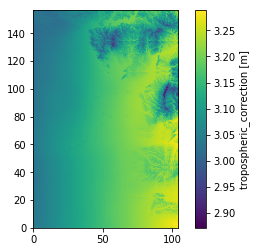

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
im = ax.imshow(tropo_correction_all*constants.c/2, extent=[x_axis[0],x_axis[-1], y_axis[0], y_axis[-1]],)
fig.colorbar(im,label='tropospheric_correction [m]')
plt.show()


0 0 46.91618146037102 20.86099246659923
0 -1 47.107582519740895 20.809209509085747
-1 -1 47.2624591566096 22.116579826046983
-1 0 47.07110265784744 22.164301856845817


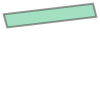

In [10]:
from shapely.geometry import Polygon, MultiPolygon
from shapely.geometry import Point
lats = burst_dataset._grp['lats']
lons = burst_dataset._grp['lons']
heights = burst_dataset._grp['height']
#find the corners

corner_list=[(0,0), (0,-1), (-1,-1), (-1,0)]
etaf_burst_footprint=[]
for corner in corner_list:
    x,y = corner
    lat_= lats[corner]
    lon_= lons[corner]
    h_ = heights[corner]
    print (x,y, lat_, lon_)
    etaf_burst_footprint.append ((lon_, lat_, h_))
etaf_burst_footprint=Polygon(etaf_burst_footprint)
    
etaf_burst_footprint

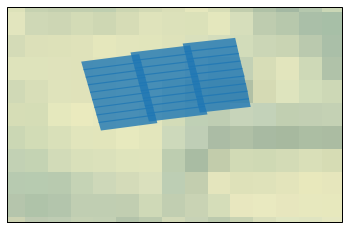

In [36]:

import cartopy.crs as ccrs
import cartopy.feature as cfeature



def tile_extent(poly, widen_area = 2):
    bb = list(poly.bounds)
    bb [1:3] = bb [2:0:-1]
    bb2 = np.asarray(bb)  + [-widen_area,widen_area,-widen_area,widen_area]
    return bb2


df = eta_.query_burst_by_time(first_time, last_time)
swath_polys =[]
for swath_ in df.swathID.unique():
    #for each swath get the burst recursively
    swath_polys.append(MultiPolygon(eta_[swath_].get_footprint()))


ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(tile_extent(MultiPolygon(swath_polys)))

# Put a background image on for nice sea rendering.
ax.stock_img()


ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
for polys in swath_polys:
    ax.add_geometries(polys,crs=ccrs.PlateCarree(), alpha=0.8)

plt.show()


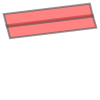

In [17]:
MultiPolygon(swath_dataset.get_footprint(burst_index_list=[2,5]))